In [2]:
import pandas as pd
import numpy as np

# ---------------- CONFIG ----------------
DATA_PATH = "/content/T1.csv"

DATETIME_COL_CANDIDATES = ["Date/Time", "Date", "Timestamp", "DATE/TIME"]

# ---------------- Helper: Fuzzy Column Match ----------------
def fuzzy_col_map(df_cols):
    cols_lower = {c.lower(): c for c in df_cols}

    def find(key):
        key = key.lower()
        for k,v in cols_lower.items():
            if key in k:
                return v
        return None

    mapping = {}

    # datetime
    for cand in DATETIME_COL_CANDIDATES:
        if cand.lower() in cols_lower:
            mapping["datetime"] = cols_lower[cand.lower()]
            break
    if "datetime" not in mapping:
        for k in cols_lower:
            if "date" in k or "time" in k:
                mapping["datetime"] = cols_lower[k]
                break

    # other columns
    mapping["power"] = find("activepower") or find("lv active")
    mapping["wind"] = find("wind speed")
    mapping["theoretical"] = find("theoretical")
    mapping["direction"] = find("direction")

    return mapping

# ---------------- Read CSV ----------------
df = pd.read_csv("/content/T1.csv")
print("Columns detected:", df.columns.tolist())

# Apply mapping
mapping = fuzzy_col_map(df.columns)
print("Column Mapping:", mapping)

# ---------------- Parse datetime ----------------
df[mapping["datetime"]] = pd.to_datetime(
    df[mapping["datetime"]].astype(str).str.strip(),
    dayfirst=True,
    errors="coerce"
)

df = df.dropna(subset=[mapping["datetime"]])
df = df.sort_values(mapping["datetime"]).reset_index(drop=True)
df.set_index(mapping["datetime"], inplace=True)

print("Data Loaded Successfully!")
df.head()


Columns detected: ['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
Column Mapping: {'datetime': 'Date/Time', 'power': 'LV ActivePower (kW)', 'wind': 'Wind Speed (m/s)', 'theoretical': 'Theoretical_Power_Curve (KWh)', 'direction': 'Wind Direction (°)'}
Data Loaded Successfully!


,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


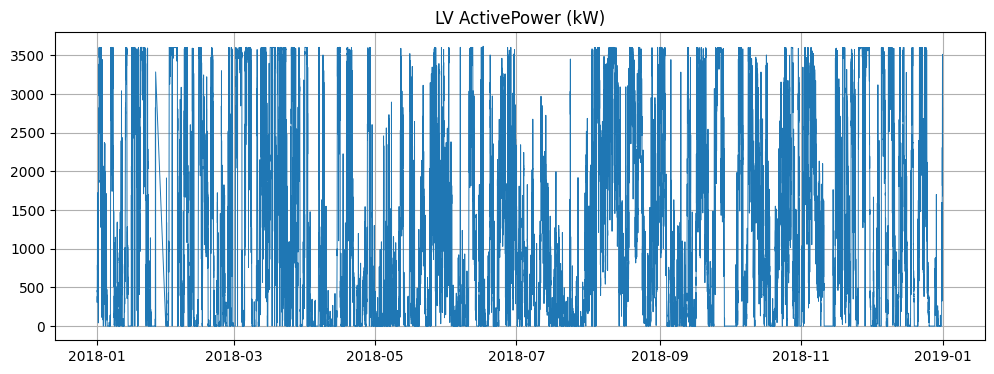

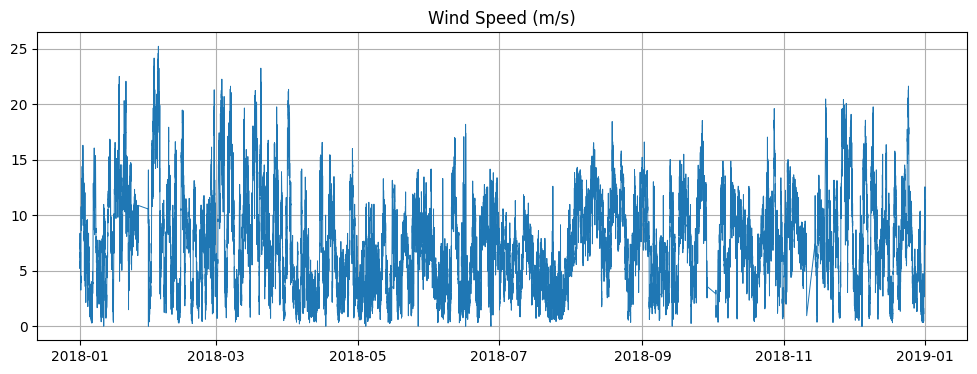

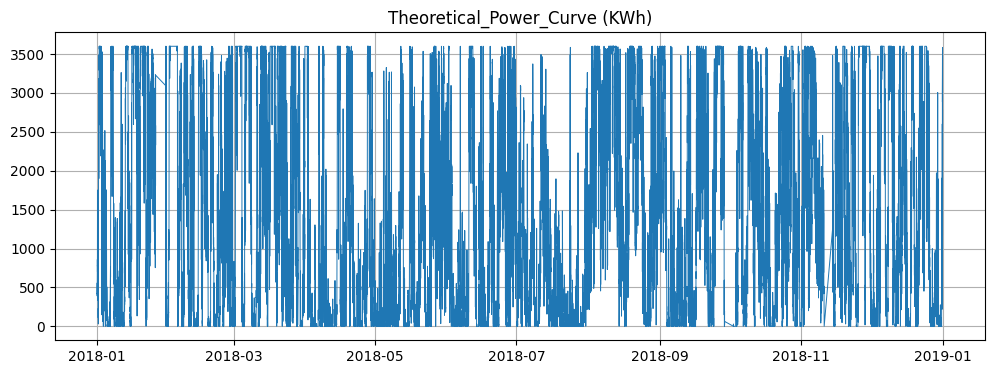

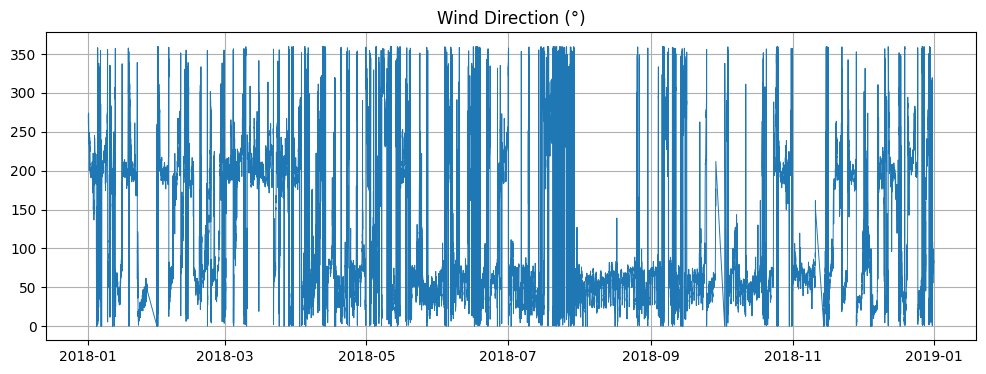

Missing Values:
 LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

Summary Statistics:
       LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
count         50530.000000      50530.000000                   50530.000000   
mean           1307.684332          7.557952                    1492.175463   
std            1312.459242          4.227166                    1368.018238   
min              -2.471405          0.000000                       0.000000   
25%              50.677890          4.201395                     161.328167   
50%             825.838074          7.104594                    1063.776283   
75%            2482.507568         10.300020                    2964.972462   
max            3618.732910         25.206011                    3600.000000   

       Wind Direction (°)  
count        50530.000000  
mean           123.687559  
std          

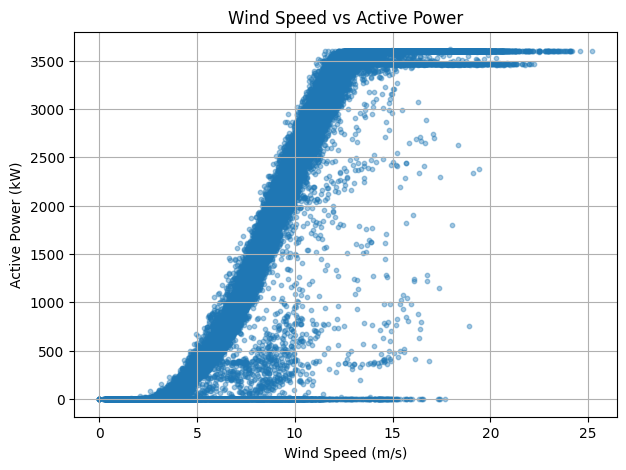

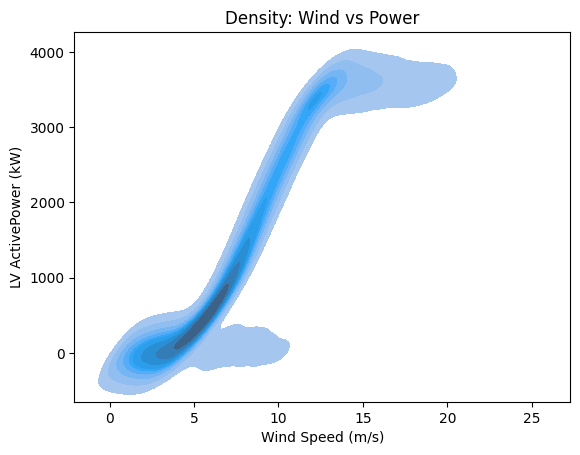

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

COL_POWER = mapping["power"]
COL_WIND = mapping["wind"]
COL_THEO = mapping["theoretical"]
COL_DIR = mapping["direction"]

# --- Time Series Plots ---
def plot_ts(col):
    plt.figure(figsize=(12,4))
    plt.plot(df.index, df[col], lw=0.7)
    plt.title(col)
    plt.grid(True)
    plt.show()

for col in [COL_POWER, COL_WIND, COL_THEO, COL_DIR]:
    plot_ts(col)

# --- Missing Values ---
print("Missing Values:\n", df[[COL_POWER, COL_WIND, COL_THEO, COL_DIR]].isna().sum())

# --- Summary Stats ---
print("\nSummary Statistics:")
print(df[[COL_POWER, COL_WIND, COL_THEO, COL_DIR]].describe())

# --- Scatter: Power Curve ---
plt.figure(figsize=(7,5))
plt.scatter(df[COL_WIND], df[COL_POWER], s=10, alpha=0.4)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Active Power (kW)")
plt.title("Wind Speed vs Active Power")
plt.grid(True)
plt.show()

# --- Density Plot ---
sns.kdeplot(
    x=df[COL_WIND].dropna(),
    y=df[COL_POWER].dropna(),
    fill=True
)
plt.title("Density: Wind vs Power")
plt.show()



=== Forecasting LV ActivePower (kW) ===
MAE: 137.9458820864134
RMSE: 240.37943436133207


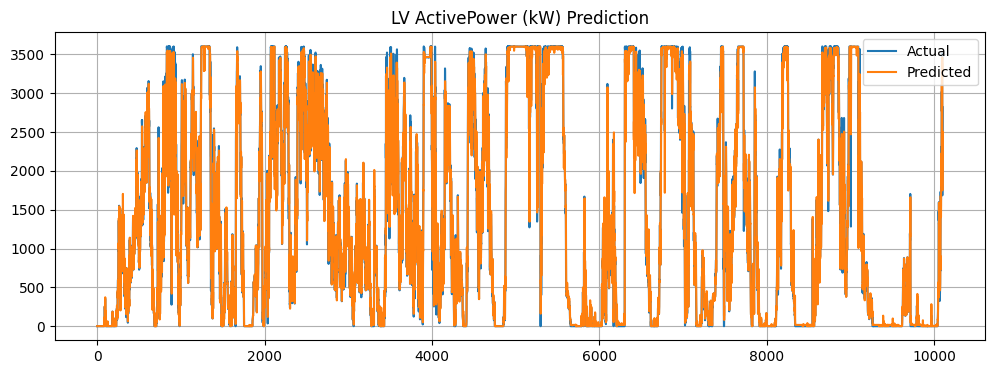


=== Forecasting Wind Speed (m/s) ===
MAE: 0.556256090520206
RMSE: 0.7824613024078569


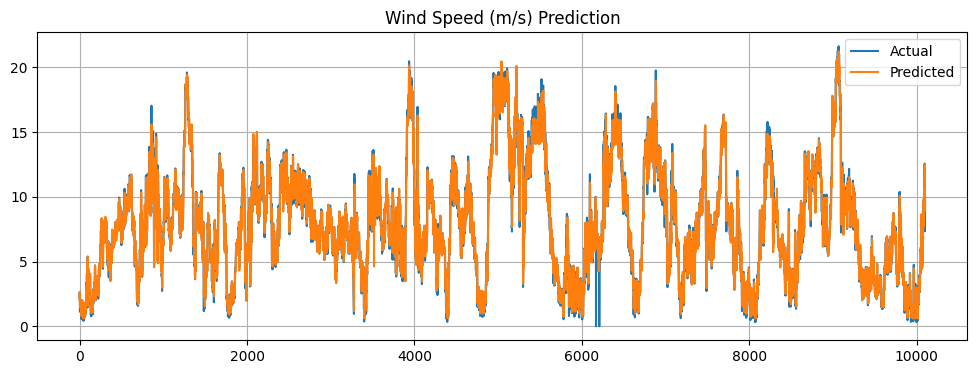


=== Forecasting Theoretical_Power_Curve (KWh) ===


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

LOOKBACK = 24
TEST_RATIO = 0.2

df_clean = df[[COL_POWER, COL_WIND, COL_THEO, COL_DIR]].ffill().bfill()

def create_window(data, target):
    arr = data.values
    target_idx = data.columns.get_loc(target)

    # Fast window (creates shape: (n_windows, LOOKBACK, n_features))
    X_windows = np.lib.stride_tricks.sliding_window_view(arr, (LOOKBACK, arr.shape[1]))[:, 0, :, :]

    # Trim X_windows to match the number of y samples (N - LOOKBACK)
    X = X_windows[:-1]

    # Flatten (n_samples, LOOKBACK * n_features)
    n_samples = X.shape[0]
    X = X.reshape(n_samples, LOOKBACK * arr.shape[1])

    # Target aligned correctly
    y = arr[LOOKBACK:, target_idx]

    return X, y



# --- Train Test Split ---
def forecast_feature(target):
    print(f"\n=== Forecasting {target} ===")

    X, y = create_window(df_clean, target)
    n_test = int(len(X) * TEST_RATIO)

    X_train, X_test = X[:-n_test], X[-n_test:]
    y_train, y_test = y[:-n_test], y[-n_test:]

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = RandomForestRegressor(
    n_estimators=50,     # 4x faster
    max_depth=12,        # prevents deep slow trees
    n_jobs=-1,           # use all CPU cores
    random_state=42
)

    model.fit(X_train, y_train)

    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print("MAE:", mae)
    print("RMSE:", rmse)

    plt.figure(figsize=(12,4))
    plt.plot(y_test, label="Actual")
    plt.plot(pred, label="Predicted")
    plt.title(f"{target} Prediction")
    plt.legend()
    plt.grid(True)
    plt.show()

for col in [COL_POWER, COL_WIND, COL_THEO, COL_DIR]:
    forecast_feature(col)

Anomaly Threshold: 102.14525218037073
Total Anomalies: 79


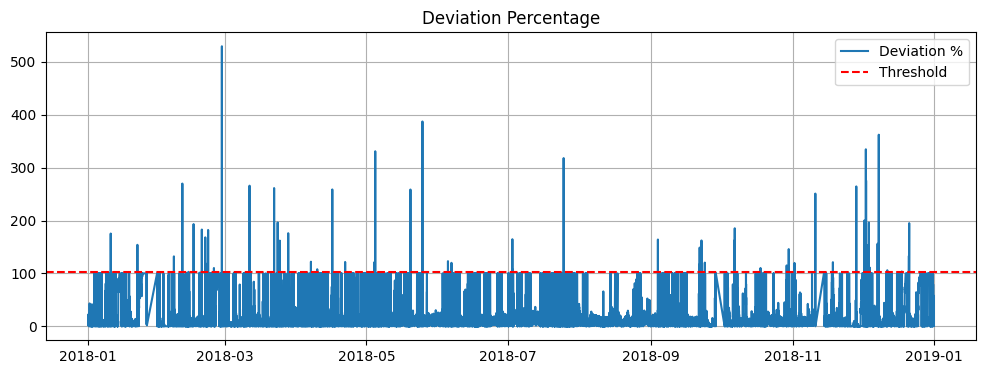

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),abs_diff,pct_diff,ratio,ratio_clip,score,category,suggestion
Date/Time,,,,,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,36.281117,8.714532,0.912855,0.912855,76.071223,Good,Optimal performance.
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,66.148316,12.722848,0.872772,0.872772,72.730960,Moderate,Investigate wind fluctuations or minor efficie...
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,84.523429,21.622774,0.783772,0.783772,65.314355,Moderate,Investigate wind fluctuations or minor efficie...
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,96.481664,18.693375,0.813066,0.813066,67.755520,Moderate,Investigate wind fluctuations or minor efficie...
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,111.052276,22.585236,0.774148,0.774148,64.512303,Moderate,Investigate wind fluctuations or minor efficie...


In [5]:
df_clean = df[[COL_POWER, COL_WIND, COL_THEO, COL_DIR]].ffill().bfill()

# --- Deviation ---
df2 = df_clean.copy()
df2["abs_diff"] = (df2[COL_THEO] - df2[COL_POWER]).abs()
df2["pct_diff"] = df2["abs_diff"] / df2[COL_THEO].replace(0, np.nan) * 100
df2["pct_diff"] = df2["pct_diff"].fillna(0)

# --- Threshold: mean + 3*std ---
threshold = df2["pct_diff"].mean() + 3 * df2["pct_diff"].std()
print("Anomaly Threshold:", threshold)

anomalies = df2[df2["pct_diff"] > threshold]
print("Total Anomalies:", len(anomalies))
anomalies.head()

# --- Plot ---
plt.figure(figsize=(12,4))
plt.plot(df2.index, df2["pct_diff"], label="Deviation %")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.legend()
plt.grid(True)
plt.title("Deviation Percentage")
plt.show()

# ---------------- Turbine Performance Score ----------------
df2["ratio"] = df2[COL_POWER] / df2[COL_THEO].replace(0, np.nan)
df2["ratio_clip"] = df2["ratio"].clip(0, 1.2)
df2["score"] = (df2["ratio_clip"] / 1.2) * 100

def category(score):
    if score >= 75: return "Good"
    elif score >= 40: return "Moderate"
    else: return "Poor"

df2["category"] = df2["score"].apply(category)

# Suggestion engine
def suggestion(row):
    if row["category"] == "Good":
        return "Optimal performance."
    if row["category"] == "Moderate":
        return "Investigate wind fluctuations or minor efficiency losses."
    return "Poor: Check blades, yaw misalignment, gearbox, or SCADA issues."

df2["suggestion"] = df2.apply(suggestion, axis=1)

df2.head()

# Optional export
# df2.to_csv("turbine_performance_results.csv")
# anomalies.to_csv("anomalies.csv")